In [1]:
"""Script for optimization of a single topology"""
import multiprocess
import numpy as np
import matplotlib.pyplot as plt

from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import (
    TwoLinkGenerator,
    visualize_constrains,
)

from auto_robot_design.optimization.saver import (
    ProblemSaver,
)
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point,
)
from auto_robot_design.optimization.problems import (
    CalculateCriteriaProblemByWeigths,
    CalculateCriteriaMeanMultiTraj,
    CalculateCriteriaMeanTraj,
    get_optimizing_joints,
)
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import (
    ActuatedMass,
    EffectiveInertiaCompute,
    ImfCompute,
    ManipCompute,
    MovmentSurface,
    NeutralPoseMass,
    TranslationErrorMSE,
    ManipJacobian,
)
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import (
    convert_x_y_to_6d_traj_xz,
    get_simple_spline,
    get_vertical_trajectory,
    create_simple_step_trajectory,
)
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import (
    HeavyLiftingReward,
    AccelerationCapability,
)
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import (
    EndPointZRRReward,
    VelocityReward,
    ForceEllipsoidReward,
)
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import (
    TMotor_AK10_9,
    TMotor_AK60_6,
    TMotor_AK70_10,
    TMotor_AK80_64,
    TMotor_AK80_9,
)
from auto_robot_design.description.builder import (
    ParametrizedBuilder,
    DetailedURDFCreatorFixedEE,
    jps_graph2pinocchio_robot,
)
from auto_robot_design.simulation.trajectory_movments import TrajectoryMovements
import auto_robot_design.simulation.evaluation as eval

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Computer Modern Serif",
})

In [11]:
import os
import dill

save_images = True
load_ctrl = True

# AC
# test_2024-05-07_18-01-32_13reverse_RH5
# test_2024-05-07_19-59-49_15reverse_RH5
# test_2024-05-07_22-05-47_17reverse_RH5
# HL
# test_2024-05-07_21-10-16_16reverse_RH5
# test_2024-05-08_17-42-51_2_RH5
# test_2024-05-09_14-51-56_8_RH5

path = "results/test_2024-05-09_14-51-56_8_RH5"
new_path = "results/test_2024-05-09_14-51-56_8_RH5_1"
path_to_ctrl = "results/test_2024-05-09_14-51-56_8_RH5_1"

with open(os.path.join(path, "ctrl_coeffs.pkl"), "rb") as f:
    coeffs = dill.load(f)

# 11rev: ids = [44, 147, 411, 555]
# 17rev: ids = [9, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230]
# 8: 
ids = [147, 178, 195, 216, 220, 224, 236, 241, 247, 251]


In [3]:
actuator = TMotor_AK10_9()
# actuator = TMotor_AK60_6()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)

# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.2, -0.85], step_height= 0.1, step_width=0.4,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.4, -0.85], step_height= 0.1, step_width=0.4,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.0, -0.85], step_height= 0.1, step_width=0.4,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, -0.1,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, 0.1,50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1e6), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
step_trajectories = [ground_symmetric_step, right_shift_step]

rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1e6),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1)]

vertical_trajectories = [central_vertical, left_vertical, right_vertical]
vertical_trajectories = [central_vertical, left_vertical]

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]

In [4]:
from auto_robot_design.optimization.saver import (
    load_checkpoint,
)


n_proccess = 8
pool = multiprocess.Pool(n_proccess)
runner = StarmapParallelization(pool.starmap)

problem = CalculateCriteriaProblemByWeigths.load(
    path,
    builder,
    crag,
    **{"elementwise_runner":runner})
checklpoint = load_checkpoint(path)

optimizer = PymooOptimizer(problem, checklpoint)
optimizer.load_history(path)


best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]

In [5]:
# problem.mutate_JP_by_xopt(problem.initial_xopt)
# draw_joint_point(problem.graph)
# for _, trajectories in rewards_and_trajectories:
#     for trajectory in trajectories:
#         plt.plot(trajectory[:,0],trajectory[:,2])
# plt.figure()
# problem.mutate_JP_by_xopt(best_x)
# draw_joint_point(problem.graph)
# for _, trajectories in rewards_and_trajectories:
#     for trajectory in trajectories:
#         plt.plot(trajectory[:,0],trajectory[:,2])

In [5]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

partial_rewards = []
for x_var, name in zip([problem.initial_xopt, best_x], ["Initial", "Best"]):
    problem.mutate_JP_by_xopt(x_var)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
    print(name)
    for rewards, trajectories in rewards_and_trajectories:
        mean_reward = np.zeros(len(trajectories))
        mean_partial = np.zeros((len(trajectories),len(rewards)))
        for trajectory_id, trajectory in enumerate(trajectories):
            point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
            current_total = 0
            current_partial = []
            log = ""
            for reward, weight in rewards:
                current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
                current_total += weight*current_partial[-1]
                log += f"{reward.__class__.__name__}: {np.round(current_partial[-1],3)} "
            print(log)
            mean_reward[trajectory_id] = current_total
            mean_partial[trajectory_id] = current_partial
        total_reward = np.mean(mean_reward)
        partial_rewards.append([total_reward]+list(np.mean(mean_partial, axis=0)))
        print(f"Rewards: {[reward.__class__.__name__ for reward, _ in rewards]}")
        print('Total reward:', total_reward.round(5), 'partial rewards at best trajectory:', partial_rewards[-1][1:])
        print()
    print("=====================")


Initial
PositioningReward: -0.048 AccelerationCapability: 0 
PositioningReward: -0.198 AccelerationCapability: 0 
Rewards: ['PositioningReward', 'AccelerationCapability']
Total reward: -122796.99417 partial rewards at best trajectory: [-0.1227969941679315, 0.0]

PositioningReward: -0.038 HeavyLiftingReward: 0 
PositioningReward: -0.01 HeavyLiftingReward: 0 
Rewards: ['PositioningReward', 'HeavyLiftingReward']
Total reward: -24251.30646 partial rewards at best trajectory: [-0.024251306456012926, 0.0]

Best
PositioningReward: 0 AccelerationCapability: 21.908 
PositioningReward: 0 AccelerationCapability: 22.249 
Rewards: ['PositioningReward', 'AccelerationCapability']
Total reward: 22.07898 partial rewards at best trajectory: [0.0, 22.07898025230533]

PositioningReward: 0 HeavyLiftingReward: 24.145 
PositioningReward: 0 HeavyLiftingReward: 20.083 
Rewards: ['PositioningReward', 'HeavyLiftingReward']
Total reward: 22.11396 partial rewards at best trajectory: [0.0, 22.113961592297972]



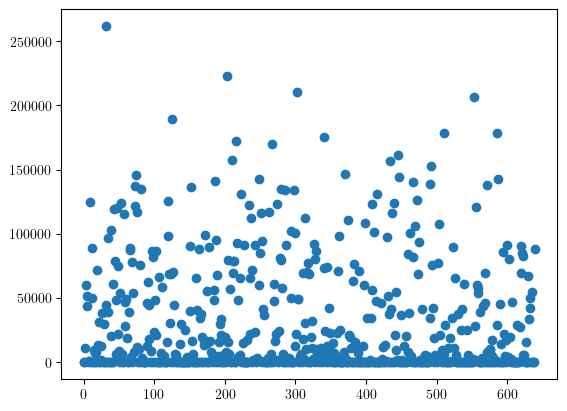

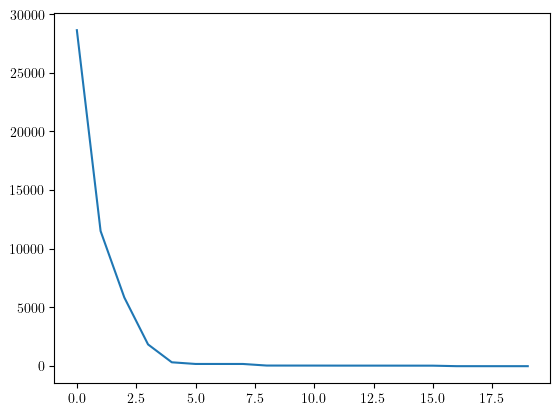

In [14]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [6]:
valid_arr_x_args = list(filter(lambda x: np.isclose(np.array(optimizer.history["Fs"])[x,0,1], 0), range(len(optimizer.history["Fs"])) ))

valid_arr_x = np.array(optimizer.history["X"])[valid_arr_x_args, :]
valid_arr_HL = np.array(optimizer.history["Fs"])[valid_arr_x_args, 1, 2]

valid_arr_X_HL = list(zip(valid_arr_x, valid_arr_HL))
valid_arr_X_HL_srtd = sorted(valid_arr_X_HL, key=lambda X_HL: X_HL[1])


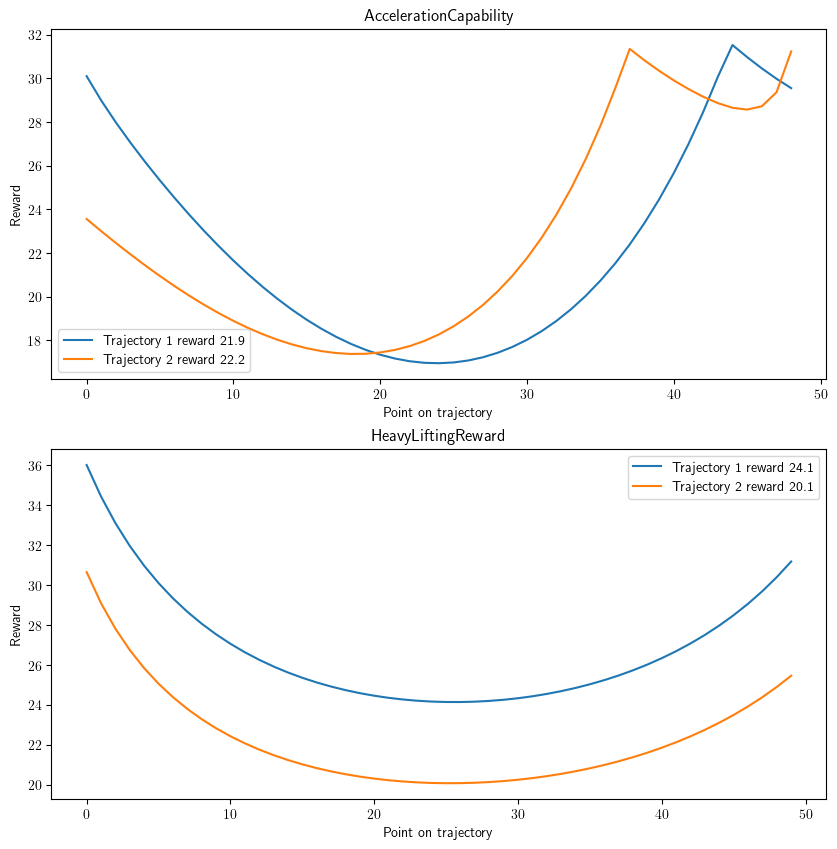

In [7]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
fig, axs, = plt.subplots(len(rewards_and_trajectories),1, figsize=(10,10))
for reward_n_traj, ax in zip(rewards_and_trajectories, axs):
    reward = reward_n_traj[0][1][0]
    trajectories = reward_n_traj[1]
    for traj, id in zip(trajectories, range(len(trajectories))):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, traj)
        cost = reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[0]
        reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
        ax.plot(reward_vector, label=f"Trajectory {id + 1} reward {cost.round(1)}") 
        ax.set_title(reward.__class__.__name__)
        ax.set_xlabel('Point on trajectory')
        ax.set_ylabel('Reward')
        ax.legend()
if save_images:
    plt.savefig(os.path.join(path, "rewards_point.svg"))

In [8]:
for id, (X, HL) in enumerate(valid_arr_X_HL_srtd):
    print(f"HL {id}: {HL}")

HL 0: 0.0
HL 1: 0.0
HL 2: 0.0
HL 3: 0.0
HL 4: 0.0
HL 5: 0.0
HL 6: 0.0
HL 7: 0.0
HL 8: 0.0
HL 9: 0.0
HL 10: 0.0
HL 11: 0.0
HL 12: 0.0
HL 13: 0.0
HL 14: 0.0
HL 15: 0.0
HL 16: 0.0
HL 17: 0.0
HL 18: 0.0
HL 19: 0.0
HL 20: 0.0
HL 21: 0.0
HL 22: 0.0
HL 23: 0.0
HL 24: 0.0
HL 25: 0.0
HL 26: 0.0
HL 27: 0.0
HL 28: 0.0
HL 29: 0.0
HL 30: 0.0
HL 31: 0.0
HL 32: 0.0
HL 33: 0.0
HL 34: 0.0
HL 35: 0.0
HL 36: 0.0
HL 37: 0.0
HL 38: 0.0
HL 39: 0.0
HL 40: 0.0
HL 41: 0.0
HL 42: 0.0
HL 43: 0.0
HL 44: 0.0
HL 45: 0.0
HL 46: 0.0
HL 47: 0.0
HL 48: 0.0
HL 49: 0.0
HL 50: 0.0
HL 51: 0.0
HL 52: 0.0
HL 53: 0.0
HL 54: 0.0
HL 55: 0.0
HL 56: 0.0
HL 57: 0.0
HL 58: 0.0
HL 59: 0.0
HL 60: 0.0
HL 61: 0.0
HL 62: 0.0
HL 63: 0.0
HL 64: 0.0
HL 65: 0.0
HL 66: 0.0
HL 67: 0.0
HL 68: 0.0
HL 69: 0.0
HL 70: 0.0
HL 71: 0.0
HL 72: 0.0
HL 73: 0.12159018731372746
HL 74: 0.25377409981011884
HL 75: 0.2849635004152736
HL 76: 0.424507908097952
HL 77: 0.4488382135141981
HL 78: 0.48025489832529733
HL 79: 0.9456855695447757
HL 80: 0.94831407811188

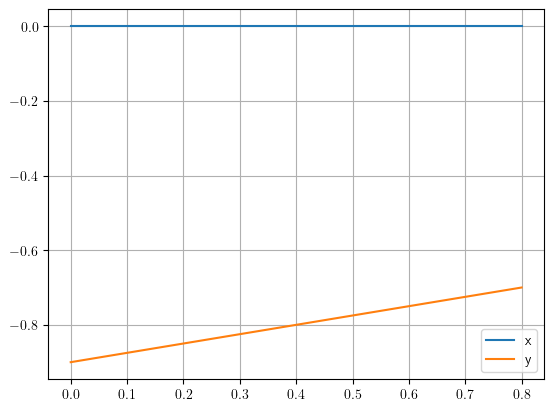

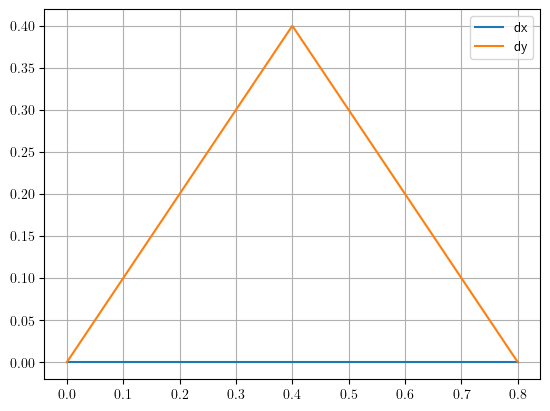

In [9]:
x_var = valid_arr_X_HL_srtd[-1][0]
problem.mutate_JP_by_xopt(x_var)
robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

name_ee = "EE"

traj = vertical_trajectories[0][:,[0,2]]
# traj =  step_trajectories[0][:,[0,2]]
test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)
time, traj6d, dtraj6d =  test.prepare_trajectory(robo)

plt.plot(time, traj6d[:,0], label="x")
plt.plot(time, traj6d[:,2], label="y")
plt.legend()
plt.grid()
if save_images:
    plt.savefig(os.path.join(new_path, "trajectory.svg"))
plt.figure()
plt.plot(time, dtraj6d[:,0], label="dx")
plt.plot(time, dtraj6d[:,2], label="dy")
plt.legend()
plt.grid()
if save_images:
    plt.savefig(os.path.join(new_path, "dtrajectory.svg"))

In [10]:
len(valid_arr_X_HL_srtd)

252

In [22]:
import warnings
warnings.filterwarnings('ignore') 


HL_designs = []
HL2ids_designs = {}
valid_HL_arr_X_srtd = np.array([valid_arr_X_HL_srtd[i][0] for i in range(len(valid_arr_X_HL_srtd))])

for id in ids:
    HL_designs.append(valid_arr_X_HL_srtd[id][1])
    HL2ids_designs[HL_designs[-1]] = id

# sorted_ctrl_coeffs = [ctrl_HL[0] for ctrl_HL in sorted(zip(ctrl_coeffs, HL_designs), key=lambda x: x[1])]
print(HL_designs)

if not load_ctrl:
    func_ctrl_rewards = []
    data = []
    for id in ids:
        x_var = valid_HL_arr_X_srtd[id, :]
        problem.mutate_JP_by_xopt(x_var)
        robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

        name_ee = "EE"

        traj = vertical_trajectories[0][:,[0,2]]
        # traj =  step_trajectories[0][:,[0,2]]
        test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)

        time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
        # test.prepare_trajectory(robo)
        
        Kp, Kd, fun = test.optimize_control(robo)
        coeffs.append((x_var, Kp, Kd))
        func_ctrl_rewards.append(fun)
        test.Kp = Kp
        test.Kd = Kd
        
        # # q, vq, acc, tau, pos_ee, power
        data.append(test.simulate(robo, False))
        print(f"HL {id}: {func_ctrl_rewards[-1]}")

    power_arrs = [data[i][5] for i in range(len(data))]
    pos_ee_arrs = [data[i][4] for i in range(len(data))]
    tau_arrs = [data[i][3] for i in range(len(data))]


    pathfile_ctrl = os.path.join(new_path, "HL_ctrl_coeffs.pkl")
    with open(pathfile_ctrl, "wb") as f:
        dill.dump(coeffs, f)
        

    pathfile_ctrl = os.path.join(new_path, "HL_ctrl_rewards.pkl")
    with open(pathfile_ctrl, "wb") as f:
        dill.dump(func_ctrl_rewards, f)

[9.33228337464334, 13.255009218972612, 15.14336955105312, 17.04305361992617, 17.9475624594696, 18.660987982494632, 19.381376202504615, 20.369998784395356, 22.113961592297972, 24.11957415096034]
HL 147: 0.8449465058958484
HL 178: 0.6658007521057911
HL 195: 0.9624524198808859
HL 216: 0.5740625220789805
HL 220: 0.6429118620485255
HL 224: 0.9124245208562722
HL 236: 0.4545934450726023
HL 241: 0.4219347643866552
HL 247: 0.37368588095879235
HL 251: 0.3558888414921489


In [14]:
if load_ctrl:
    with open(os.path.join(path_to_ctrl, "HL_ctrl_coeffs.pkl"), "rb") as f:
        coeffs = dill.load(f)
    coeffs = coeffs[5:]
    coeffs = [c for id, c in enumerate(coeffs) if not id in [2,4,5]]

HL_designs = []
HL2ids_designs = {}
valid_arr_X_srtd = np.array([valid_arr_X_HL_srtd[i][0] for i in range(len(valid_arr_X_HL_srtd))])
for x_var, __, __ in coeffs:
    id_design = int(np.argwhere(np.all(valid_arr_X_srtd == x_var, axis=1))[0].squeeze())
    HL_designs.append(valid_arr_X_HL_srtd[id_design][1])
    HL2ids_designs[HL_designs[-1]] = id_design

sorted_ctrl_coeffs = [ctrl_HL[0] for ctrl_HL in sorted(zip(coeffs, HL_designs), key=lambda x: x[1])]
print(HL_designs)

[9.33228337464334, 13.255009218972612, 17.04305361992617, 19.381376202504615, 20.369998784395356, 22.113961592297972, 24.11957415096034]


In [21]:
from auto_robot_design.simulation.trajectory_movments import ControlOptProblem

ctrl_rews = []
data = []
for x_var, Kp, Kd in coeffs[-1:]:
    problem.mutate_JP_by_xopt(x_var)
    robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

    name_ee = "EE"

    traj = vertical_trajectories[0][:,[0,2]]
    # traj =  step_trajectories[0][:,[0,2]]
    
    test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)
    ctrl_rew = ControlOptProblem(test, robo, xl=np.ones(4)*-1, xu=np.ones(4))
    
    ctrl_rews.append(ctrl_rew.evaluate(np.array([Kp[0,0], Kp[2,2], Kd[0,0], Kd[2,2]])))

    time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
    # test.prepare_trajectory(robo)
    test.Kp = Kp
    test.Kd = Kd
    
    # # q, vq, acc, tau, pos_ee, power
    data.append(test.simulate(robo, True))

power_arrs = [data[i][5] for i in range(len(data))]
pos_ee_arrs = [data[i][4] for i in range(len(data))]
tau_arrs = [data[i][3] for i in range(len(data))]
print(ctrl_rews)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
[0.3558888414921489]


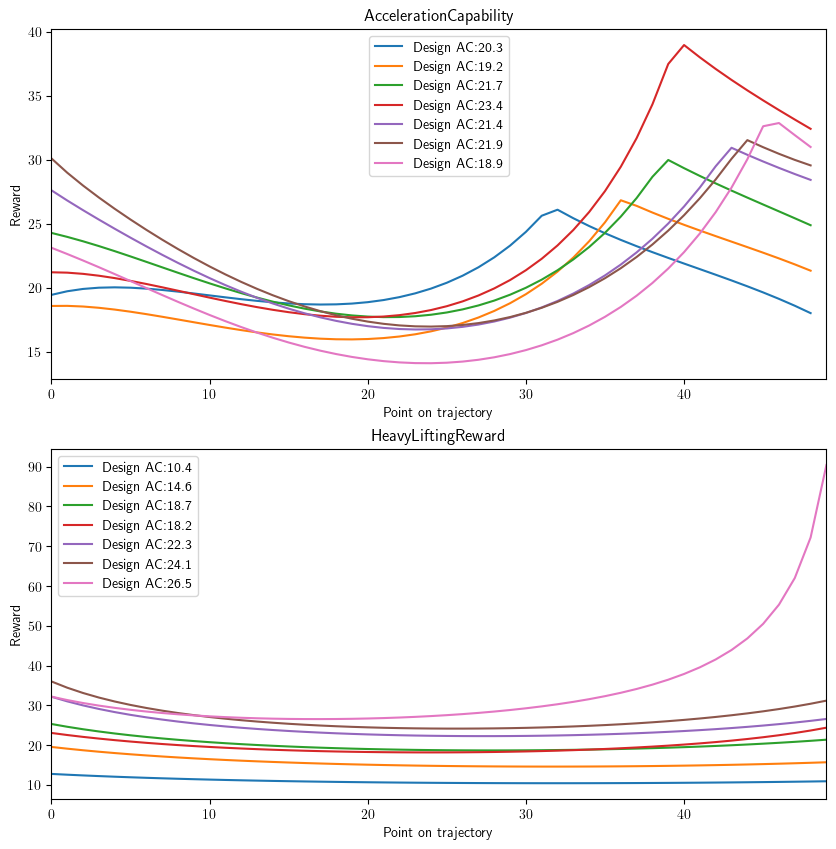

In [16]:
fig, axs, = plt.subplots(len(rewards_and_trajectories),1, figsize=(10,10))

for x_var, __, __ in coeffs:
    problem.mutate_JP_by_xopt(x_var)
    fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
    for reward_n_traj, ax in zip(rewards_and_trajectories, axs):
        reward = reward_n_traj[0][1][0]
        trajectories = reward_n_traj[1][0]
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectories)
        cost = reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[0]
        reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
        # ax.plot(reward_vector, label=f"Trajectory {id + 1} reward {cost.round(1)}") 
        ax.plot(reward_vector, label=f"Design AC:{np.round(cost, 1)}") 
        ax.set_title(reward.__class__.__name__)
        ax.set_xlabel('Point on trajectory')
        ax.set_ylabel('Reward')
        ax.set_xlim([0, 49])
        ax.legend()
if save_images:
    plt.savefig(os.path.join(new_path, "rewards_point_HL.svg"))

In [46]:
from auto_robot_design.description.builder import jps_graph2urdf_by_bulder


urdf_robot, __, __ = jps_graph2urdf_by_bulder(problem.graph, builder=builder)

pathfile_ctrl = os.path.join(new_path, "HL_urdf_robot.urdf")
with open(pathfile_ctrl, "w") as f:
    f.write(urdf_robot)

In [47]:
pathfile_ctrl = os.path.join(new_path, "HL_ctrl_rewards_test.pkl")
with open(pathfile_ctrl, "wb") as f:
    dill.dump(func_ctrl_rewards, f)

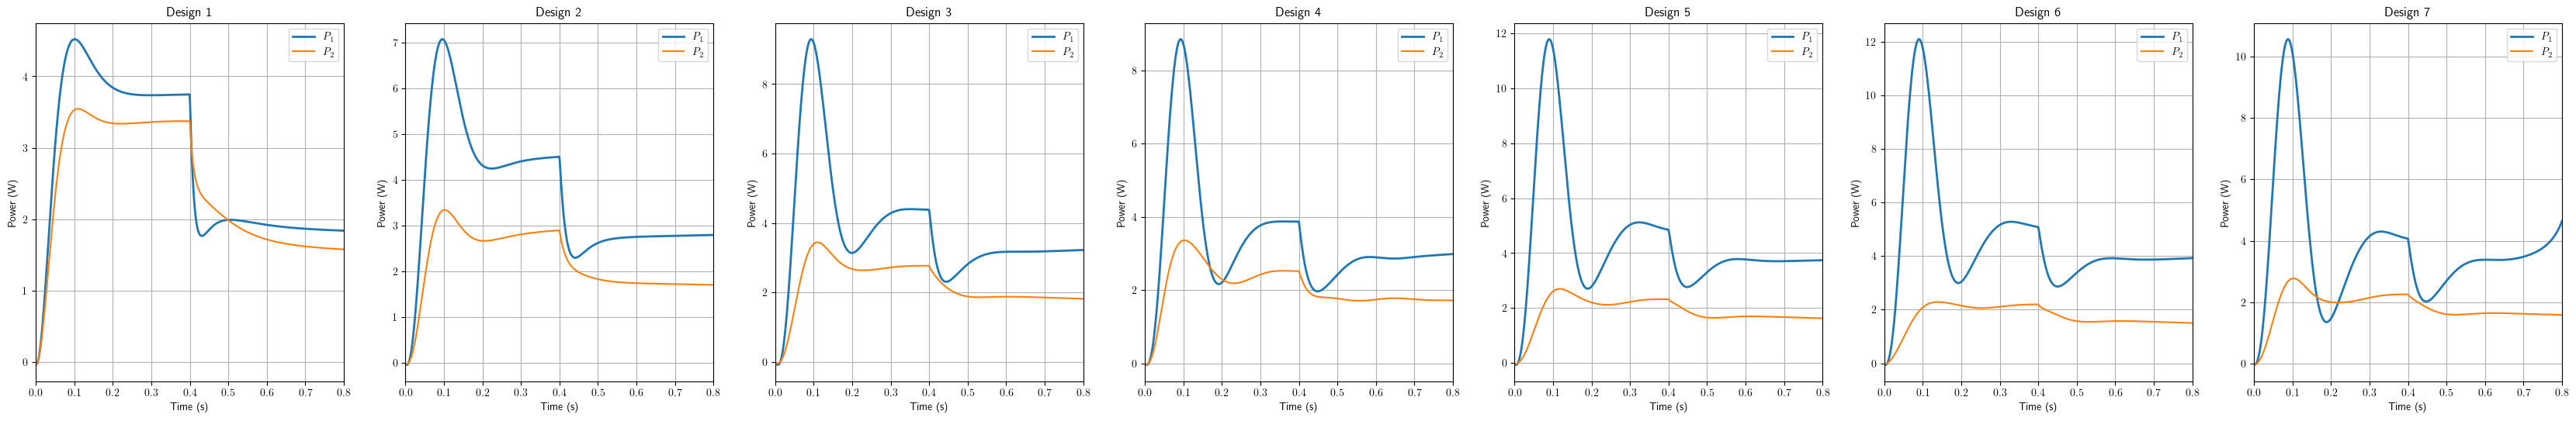

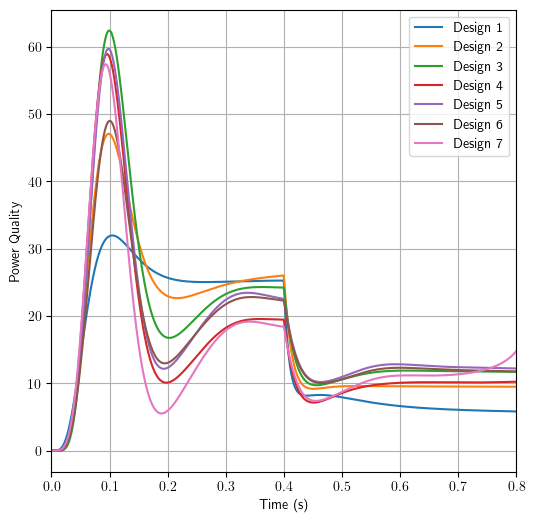

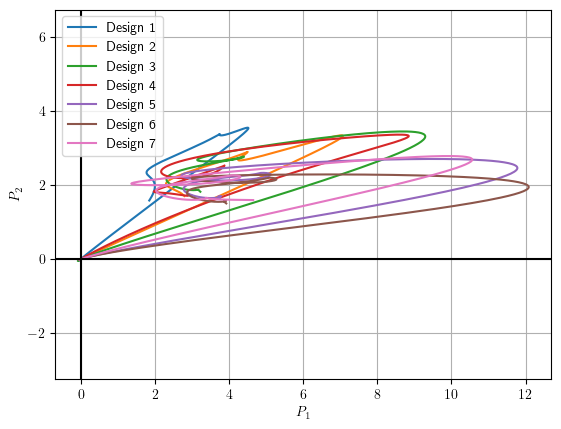

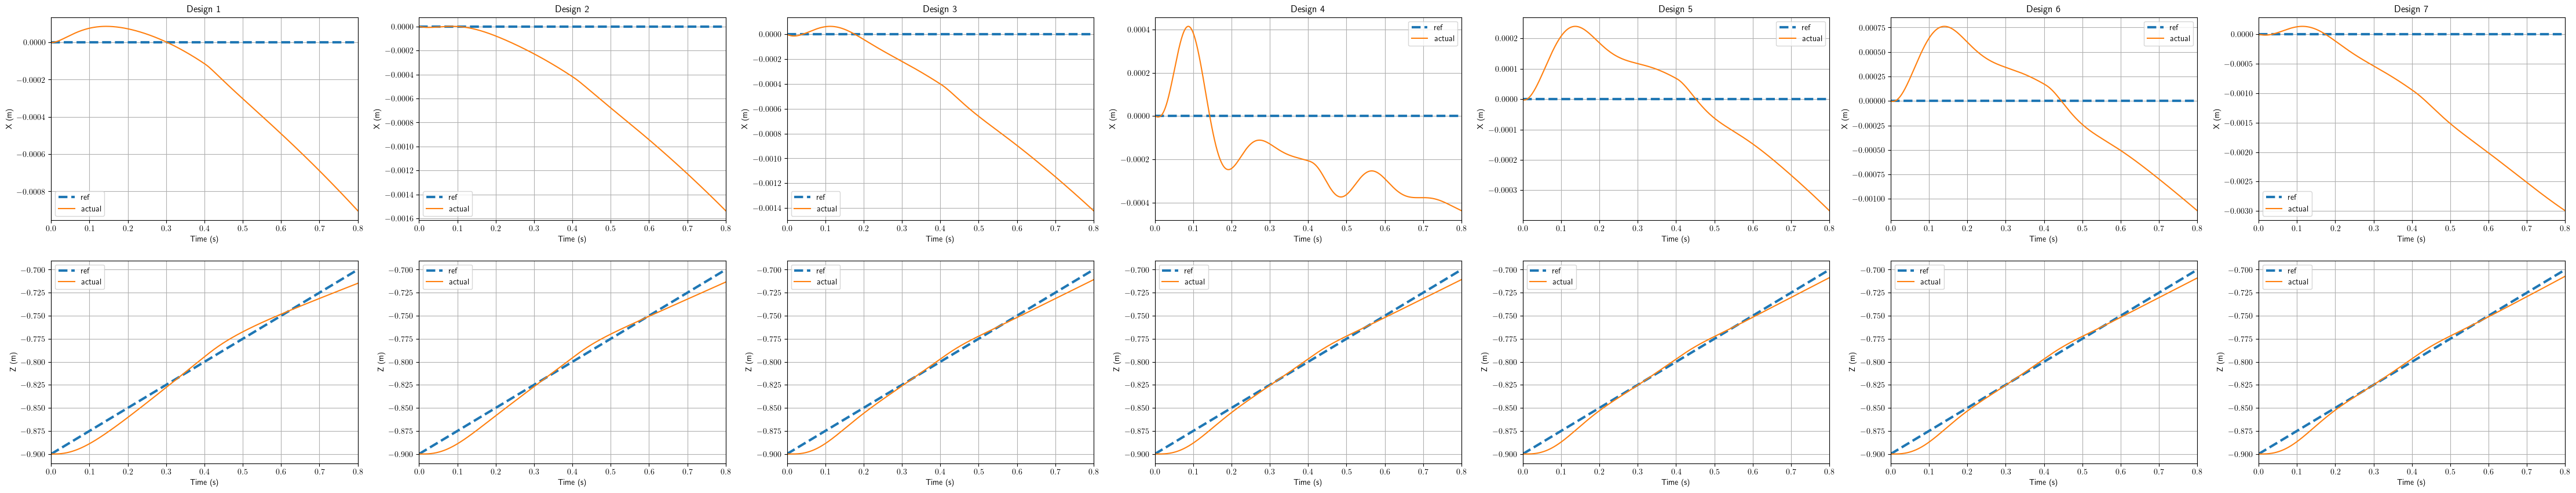

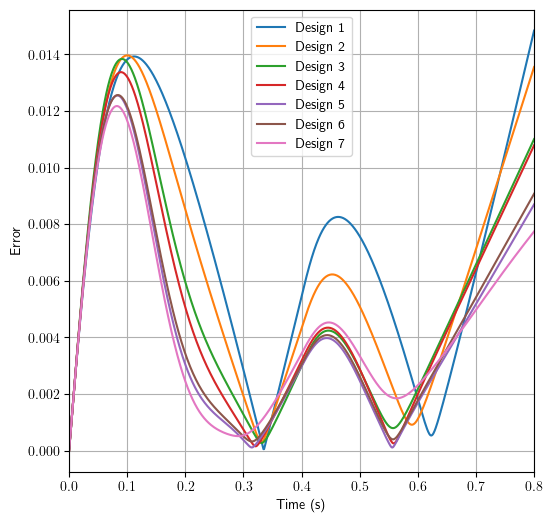

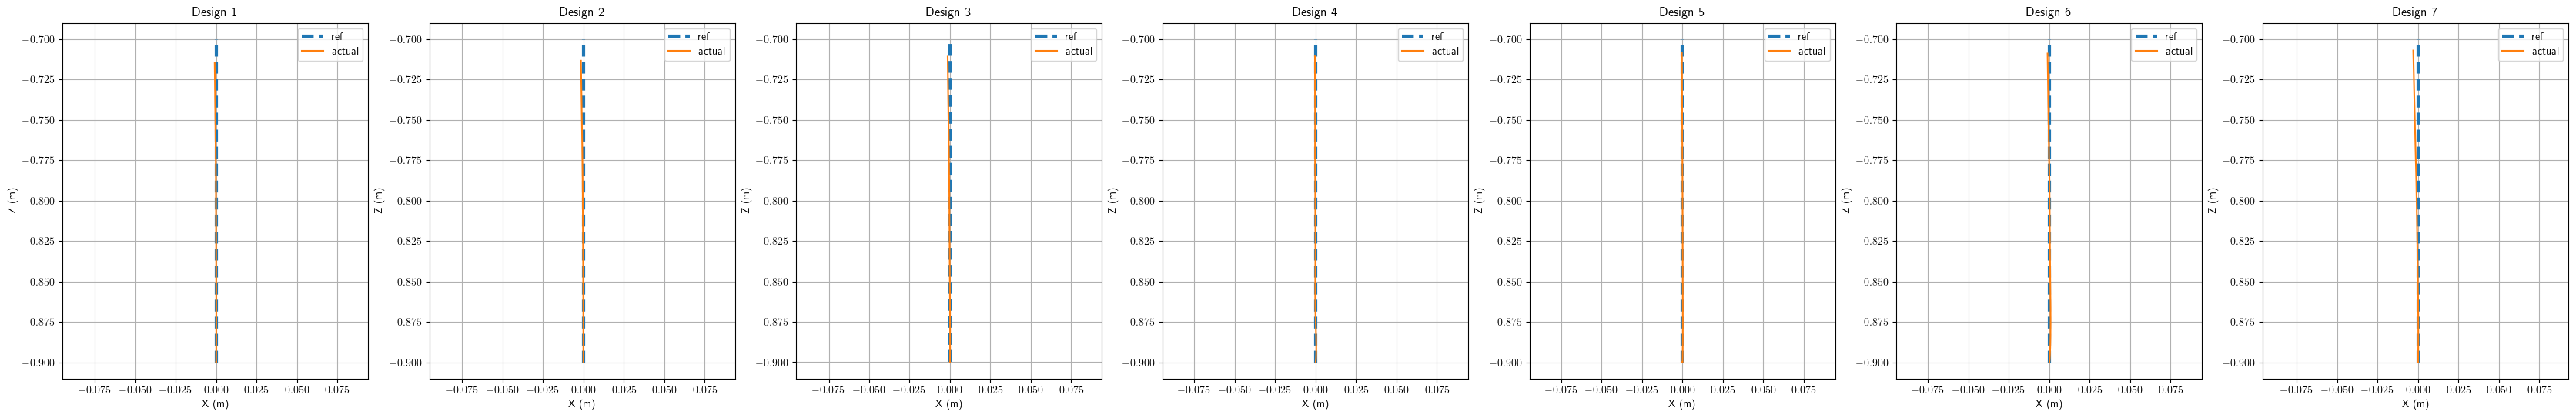

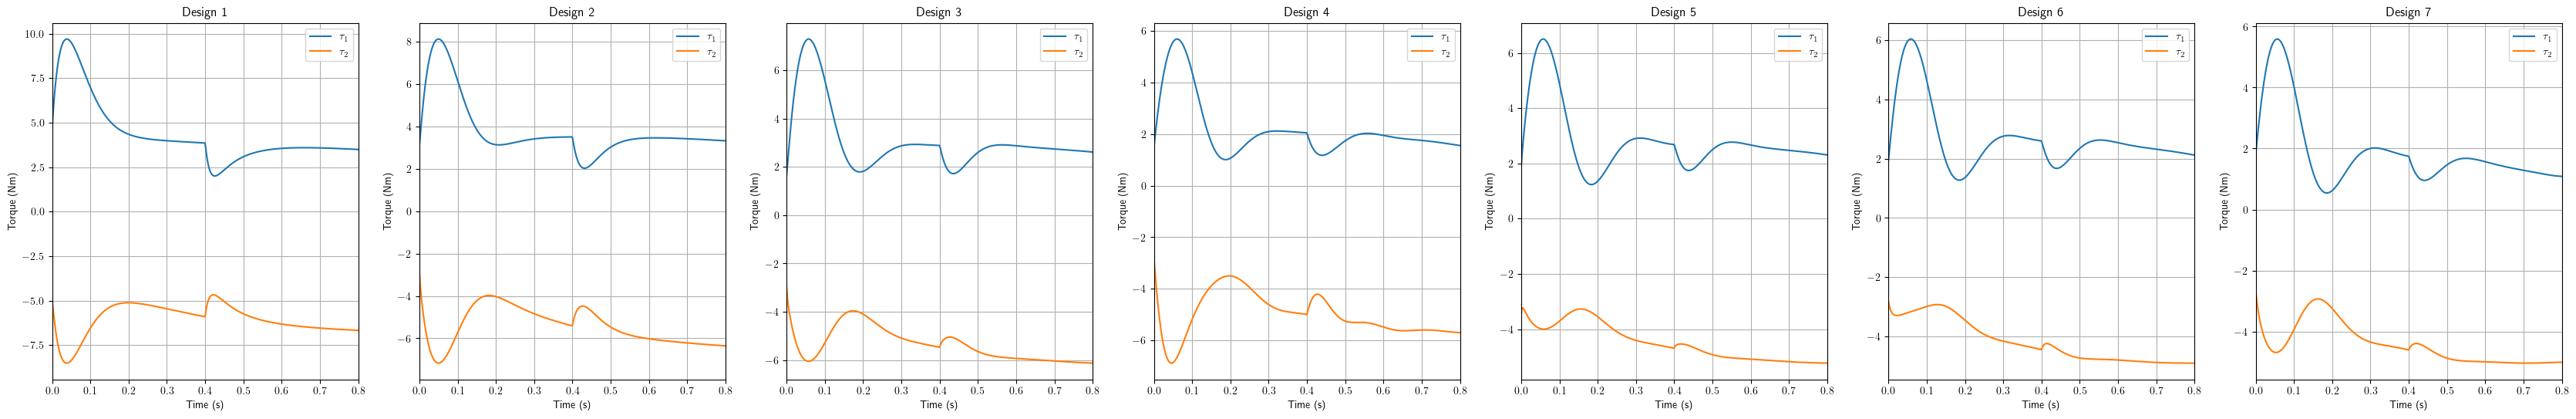

In [18]:
id2arrs = lambda arrs, ids: [arrs[id] for id in ids]
# save_images = False
if save_images:
    mean_powers, sum_power, abs_powers =  eval.compare_power_quality(time_arr, power_arrs, True, os.path.join(new_path, "HL"))
    mean_errors = eval.compare_movments_in_xz_plane(time_arr, pos_ee_arrs, des_traj_6d[:,:3], True, os.path.join(new_path, "HL"))
    max_torques, mean_torques = eval.compare_torque_evaluation(time_arr, tau_arrs, True, os.path.join(new_path, "HL"))
else:
    mean_powers, sum_power, abs_powers =  eval.compare_power_quality(time_arr, power_arrs, True)
    mean_errors = eval.compare_movments_in_xz_plane(time_arr, pos_ee_arrs, des_traj_6d[:,:3], True)
    max_torques, mean_torques = eval.compare_torque_evaluation(time_arr, tau_arrs, True)

# mean_powers, sum_power, abs_powers =  eval.compare_power_quality(time_arr, id2arrs(power_arrs, [2,-1]), True)
# mean_errors = eval.compare_movments_in_xz_plane(time_arr, id2arrs(pos_ee_arrs, [2,-1]), des_traj_6d[:,:3], True)
# max_torques, mean_torques = eval.compare_torque_evaluation(time_arr, id2arrs(tau_arrs, [2,-1]), True)

0.0022720988708338835

In [59]:
PQ = np.zeros((len(power_arrs), power_arrs[0].shape[0]))
for j in range(len(power_arrs)):
        for i in range(power_arrs[0].shape[0]):
            PQ[j,i] = np.sum(power_arrs[j][i])**2 - np.sum(power_arrs[j][i]**2)

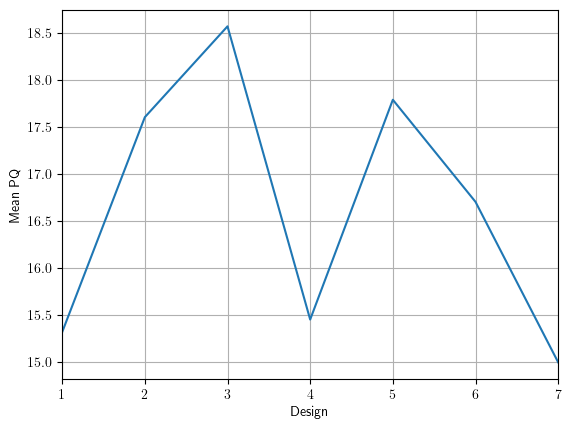

In [82]:
mean_d2PQ = np.zeros(len(power_arrs))
for j in range(len(power_arrs)):
    mean_d2PQ[j] = np.mean(PQ[j])
plt.plot(range(1,j+2), mean_d2PQ)
plt.grid()
plt.xlabel('Design')
plt.xlim([1, j+1])
plt.ylabel('Mean PQ')
if save_images:
    plt.savefig(os.path.join(new_path, "HL_d2PQ.svg"))

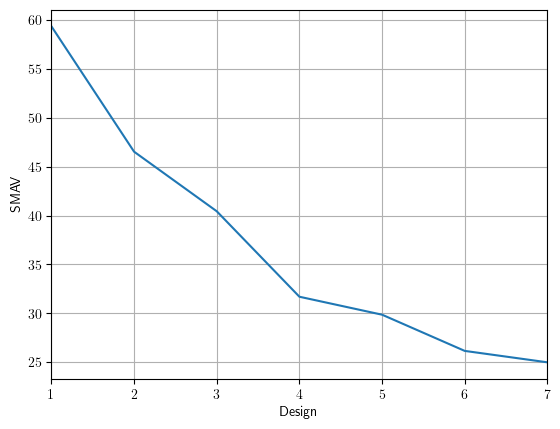

In [83]:
SMAV = np.zeros(len(pos_ee_arrs))
for j in range(len(pos_ee_arrs)):
    SMAV[j] = np.mean(np.linalg.norm(tau_arrs[j], axis=1)**2)
plt.plot(range(1,j+2),SMAV)
plt.grid()
plt.xlim([1, j+1])
plt.ylabel('SMAV')
plt.xlabel('Design')
if save_images:
    plt.savefig(os.path.join(new_path, "HL_d2SMAV.svg"))


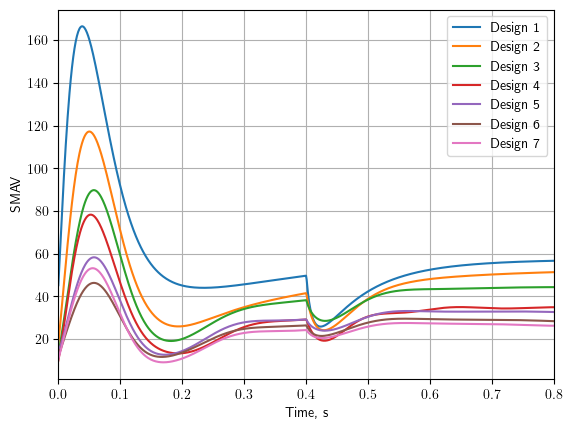

In [84]:
SMAV = np.zeros((len(tau_arrs), len(tau_arrs[0])))
for j in range(len(tau_arrs)):
    SMAV[j] = np.linalg.norm(tau_arrs[j], axis=1)**2
for j in range(len(tau_arrs)):
    plt.plot(time_arr, SMAV[j], label=f"Design {j+1}")
plt.legend()
plt.grid()
plt.xlim([0, 0.8])
plt.xlabel("Time, s")
plt.ylabel("SMAV")
if save_images:
    plt.savefig(os.path.join(new_path, "HL_SMAV2time.svg"))

In [94]:
print(f"Mean power: {mean_powers} \n Sum power: {sum_power} \n Abs power: {abs_powers}")
print(f"Mean error: {mean_errors}")
print(f"Max torque: {max_torques.T}\n Mean torque: {mean_torques.T}")

Mean power: [5.19663517 5.80023031 6.0104791  5.41414552 6.28593458 6.3180382
 5.60580539] 
 Sum power: [4156.79999164 4639.15233995 4805.62923754 4330.24282266 5027.51981306
 5053.37603074 4484.21247171] 
 Abs power: [4157.30813517 4640.1842496  4808.38327636 4331.31642    5028.74766616
 5054.43055726 4484.64431005]
Mean error: [0.00707595 0.00635042 0.00533643 0.0050686  0.00425334 0.00441944
 0.00434271]
Max torque: [[9.70042397 8.11365753 7.29025146 5.68901163 6.50516405 6.02823649
  5.59094936]
 [8.50812674 7.1676667  6.12460868 6.88477922 5.22974172 4.89118674
  5.03679275]]
 Mean torque: [[4.35595307 3.80072893 3.08747086 2.17428033 2.82242482 2.67286243
  1.87392878]
 [6.0422492  5.42697709 5.35906669 5.0056451  4.48189126 4.16647727
  4.42898454]]


In [19]:
max_tau = np.sum(max_torques, axis=1)
max_tau[0]/ max_tau[-1]

1.7133037777194993

In [20]:
np.linalg.norm(mean_torques, axis=1)[0]/np.linalg.norm(mean_torques, axis=1)[-1]

1.5488733270718595

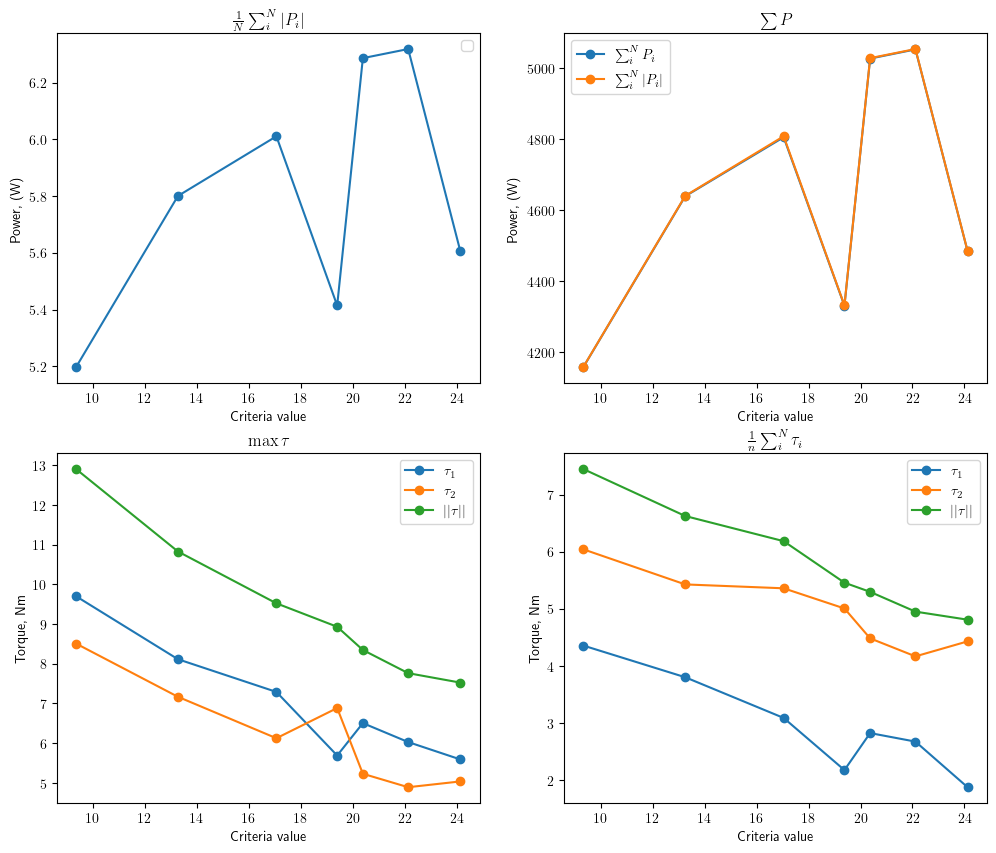

In [99]:
HL_sorted = sorted(HL_designs)

fig = plt.figure(figsize=(12, 10))
plot_name = [
    [r"$\frac{1}{N}\sum_i^N |P_i|$", r"$\sum P$"],
    [r"$\max \tau$", r"$\frac{1}{n}\sum_i^N \tau_i$"],
]
ylabel = ["Power, (W)", "Power, (W)", "Torque, Nm", "Torque, Nm"]
legend = [
    "",
    (r"$\sum_i^N P_i$", r"$\sum_i^N |P_i|$"),
    (r"$ \tau_1$", r"$ \tau_2$", r"$ ||\tau||$"),
    (r"$ \tau_1$", r"$ \tau_2$", r"$ ||\tau||$"),
]

axs = fig.subplot_mosaic(plot_name)
for reward, ax, ylab, l in (
    zip(
        [
            mean_powers,
            np.array([sum_power, abs_powers]).T,
            np.hstack((max_torques, np.linalg.norm(max_torques, axis=1)[:, np.newaxis])),
            np.hstack(
                (mean_torques, np.linalg.norm(mean_torques, axis=1)[:, np.newaxis])
            ),
        ],
        np.array(plot_name).flatten(),
        ylabel,
    legend)
):
    axs[ax].plot(HL_sorted, reward, "o-")
    axs[ax].legend(l)
    axs[ax].set_title(ax)
    axs[ax].set_xlabel("Criteria value")
    axs[ax].set_ylabel(ylab)

if save_images:
    plt.savefig(os.path.join(new_path, "HL_power_torque.svg"))

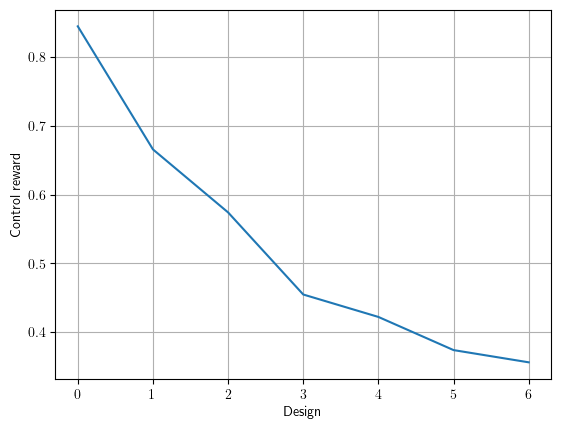

In [52]:
plt.plot(ctrl_rews)
plt.xlabel("Design")
plt.ylabel("Control reward")
plt.grid()
if save_images:
    plt.savefig(os.path.join(new_path, "HL_ctrl_rewards.svg"))


In [38]:
np.sum(max_torques,axis=1)

array([18.20855071, 15.28132423, 18.40458088, 13.41486014, 15.85456129,
       17.81902382, 12.57379085, 11.73490577, 10.91942323, 10.62774211])

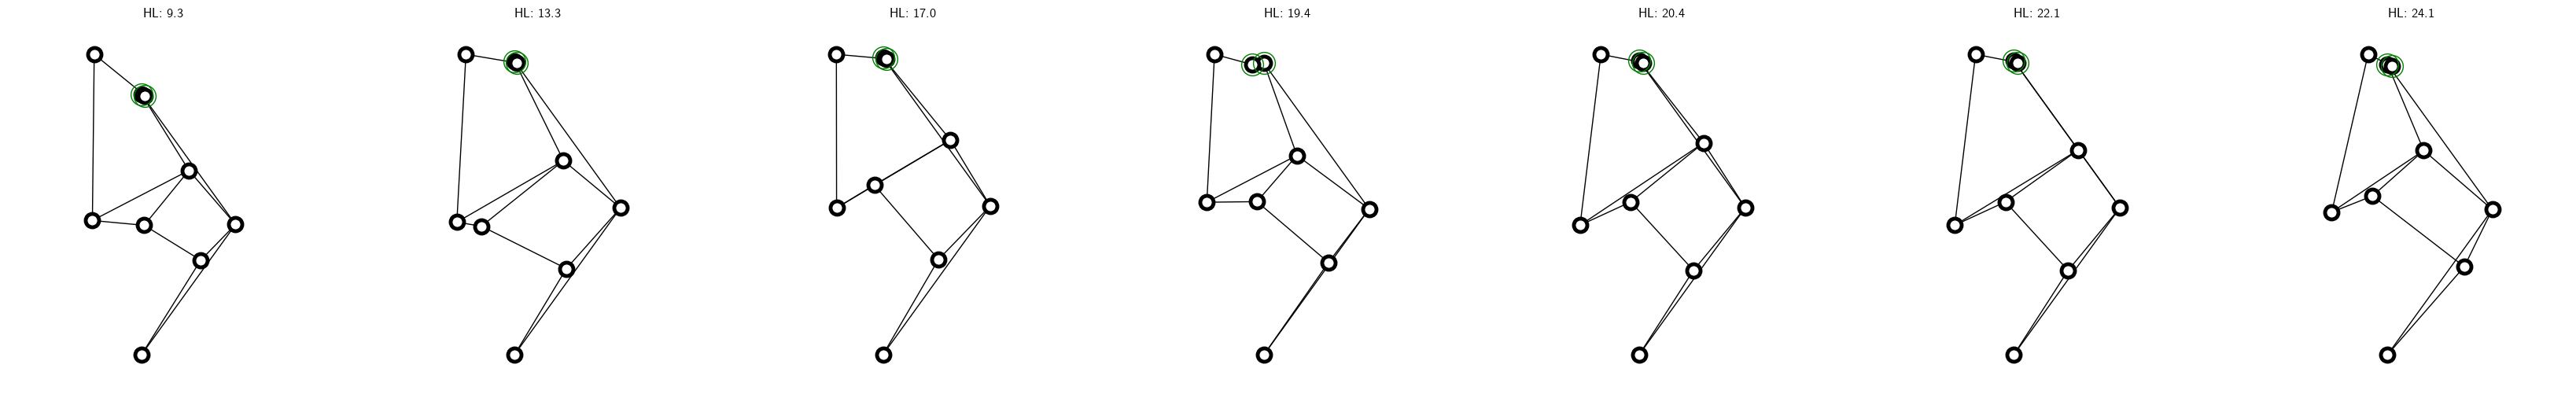

In [76]:
plt.figure(figsize=(len(HL_sorted)*6, 6))
for HL in HL_sorted:
    plt.subplot(1, len(HL_sorted), HL_sorted.index(HL) + 1)
    id_design = HL2ids_designs[HL]
    problem.mutate_JP_by_xopt(valid_arr_X_srtd[id_design])
    draw_joint_point(problem.graph)
    plt.legend('',frameon=False)
    plt.title(f"HL: {np.round(HL,1)}")
if save_images:
    plt.savefig(os.path.join(new_path, "HL_designs.pdf"))